# Library Import

In [16]:
#import cv2
import os
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from skimage import io, transform
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#data loading


In [47]:


TRAIN_DIR = "/content/drive/MyDrive/RGB_to_Thermal/Dataset/train"
VAL_DIR = "/content/drive/MyDrive/RGB_to_Thermal/Dataset/val"
TEST_DIR = "/content/drive/MyDrive/RGB_to_Thermal/Dataset/test"



In [48]:
class rgb2thermal_Dataset(Dataset):
    def __init__(self,
                 base_path,
                 transform=transforms.Compose([transforms.ToTensor()]),
                 isTrain=False):
        self.base_path = base_path
        self.rgb_imgNames = sorted(os.listdir(os.path.join(base_path, "rgb")))
        self.thermal_imgNames = sorted(os.listdir(os.path.join(base_path, "thermal")))

        self.isTrain = isTrain
        self.transform = transform


    def __getitem__(self, idx):
        rgb_imName = self.rgb_imgNames[idx]
        thermal_imName = self.thermal_imgNames[idx]

        rgb = Image.open(os.path.join(self.base_path, "rgb",  rgb_imName))
        thermal = Image.open(os.path.join(self.base_path, "thermal", thermal_imName))

        rgb_tf = self.transform(rgb)
        thermal_tf = self.transform(thermal)

        return {"rgb": rgb_tf, "thermal": thermal_tf, "fileName": rgb_imName}


    def __len__(self):
        return len(self.rgb_imgNames)

In [49]:
transform= transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [50]:

train_data = rgb2thermal_Dataset(TRAIN_DIR, transform, isTrain=True)
val_data = rgb2thermal_Dataset(VAL_DIR, transform,isTrain=False)
# test_data = rgb2thermal_Dataset(TEST_DIR, transform,isTrain=False)


In [51]:
trainLoader = DataLoader(train_data, shuffle=True, batch_size=4)
valLoader = DataLoader(val_data, shuffle=False, batch_size=4)
# testLoader = DataLoader(test_data, shuffle=False, batch_size=4)

In [52]:
def show(img):
    npimg = img.numpy()
    plt.axis(False)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

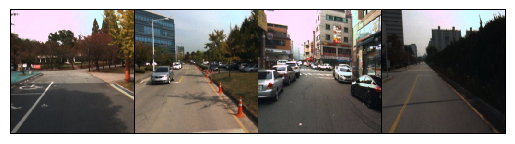

In [53]:
out = next(iter(trainLoader))
show(torchvision.utils.make_grid(out['rgb'], nrow=8))

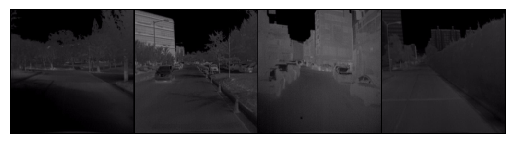

In [54]:
show(torchvision.utils.make_grid(out['thermal'], nrow=8))

In [55]:
# Assuming you've already created the 'trainLoader' data loader
for batch in trainLoader:
    rgb_images = batch['rgb']
    thermal_images = batch['thermal']

    # Print the size of the images in the batch
    print("RGB Image Size: ", rgb_images.size())
    print("Thermal Image Size: ", thermal_images.size())

    # You can break after the first batch if you only want to see the size of the first batch
    break


RGB Image Size:  torch.Size([4, 3, 256, 256])
Thermal Image Size:  torch.Size([4, 3, 256, 256])


#model definition

In [13]:
def weights_init(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def get_norm_layer():
    """Return a normalization layer
       For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    norm_type = 'batch'
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer


In [14]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer

        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)

        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.device_count()

norm_layer = get_norm_layer()

generator = UnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False)#.cuda().float()
generator.apply(weights_init)

generator = torch.nn.DataParallel(generator)  # multi-GPUs

inp = torch.ones(1, 3,256,256)
#gen = generator(inp)

inp = inp.to(device)
generator = generator.to(device)

print(summary(generator,(3,256,256)))

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initiali

In [15]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

discriminator = Discriminator(6, 64, n_layers=3, norm_layer=norm_layer)#.cuda().float()
discriminator.apply(weights_init)
discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs

inp = torch.ones(1,6,256,256)
disc = discriminator(inp)
# device = 'cuda'
# inp = inp.to(device)
# discriminator = discriminator.to(device)

summary(discriminator,(6,256,256))

adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7  

In [17]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=7ababbee9c1e2e621079dfbda379bbeb0f98624a6caa9a67484594fd354b18b5
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [18]:
import torch
from torchviz import make_dot

# Visualize the generator model
dummy_input = torch.ones(1, 3, 256, 256).to(device)
generator_flowchart = make_dot(generator(dummy_input), params=dict(generator.named_parameters()))
generator_flowchart.render("generator_flowchart", format="png", cleanup=True)

# Visualize the discriminator model
dummy_input_discriminator = torch.ones(1, 6, 256, 256).to(device)
discriminator_flowchart = make_dot(discriminator(dummy_input_discriminator), params=dict(discriminator.named_parameters()))
discriminator_flowchart.render("discriminator_flowchart", format="png", cleanup=True)

'discriminator_flowchart.png'

#training

In [72]:
learning_rate = 8e-4
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

num_epochs = 20
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs + 1):
    D_loss_list, G_loss_list = [], []

    for batch in trainLoader:
        D_optimizer.zero_grad()

        input_img = batch["rgb"]
        target_img = batch["thermal"]
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        generated_image = generator(input_img)

        disc_inp_fake = torch.cat((input_img, generated_image), 1)

        real_target = Variable(torch.ones(input_img.size(0), 1, 30, 30).to(device))
        fake_target = Variable(torch.zeros(input_img.size(0), 1, 30, 30).to(device))

        D_fake = discriminator(disc_inp_fake.detach())
        D_fake_loss = discriminator_loss(D_fake, fake_target)

        disc_inp_real = torch.cat((input_img, target_img), 1)

        output = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(output, real_target)

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)

        D_total_loss.backward()
        D_optimizer.step()

        G_optimizer.zero_grad()
        fake_gen = torch.cat((input_img, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, target_img, G, real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
        (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)), torch.mean(torch.FloatTensor(G_loss_list))))

    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))
    torch.save(generator.state_dict(), '/content/drive/MyDrive/RGB_to_Thermal/Model_file/generator_epoch_%d.pth' % epoch)
    torch.save(discriminator.state_dict(), '/content/drive/MyDrive/RGB_to_Thermal/Model_file/discriminator_epoch_%d.pth' % epoch)

Epoch: [1/20]: D_loss: 0.589, G_loss: 3.855
Epoch: [2/20]: D_loss: 0.597, G_loss: 3.757
Epoch: [3/20]: D_loss: 0.587, G_loss: 3.765
Epoch: [4/20]: D_loss: 0.790, G_loss: 3.599
Epoch: [5/20]: D_loss: 0.604, G_loss: 3.449
Epoch: [6/20]: D_loss: 0.592, G_loss: 3.571
Epoch: [7/20]: D_loss: 0.588, G_loss: 3.556
Epoch: [8/20]: D_loss: 0.592, G_loss: 3.565
Epoch: [9/20]: D_loss: 0.591, G_loss: 3.492
Epoch: [10/20]: D_loss: 0.597, G_loss: 3.463
Epoch: [11/20]: D_loss: 0.576, G_loss: 3.466
Epoch: [12/20]: D_loss: 0.851, G_loss: 3.200
Epoch: [13/20]: D_loss: 0.578, G_loss: 3.355
Epoch: [14/20]: D_loss: 0.582, G_loss: 3.367
Epoch: [15/20]: D_loss: 0.582, G_loss: 3.328
Epoch: [16/20]: D_loss: 0.738, G_loss: 3.050
Epoch: [17/20]: D_loss: 0.608, G_loss: 3.030
Epoch: [18/20]: D_loss: 0.633, G_loss: 3.238
Epoch: [19/20]: D_loss: 0.635, G_loss: 2.968
Epoch: [20/20]: D_loss: 0.538, G_loss: 3.867


In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create an iterator for the data loader
data_iter = iter(valLoader)

# Initialize a list to store PSNR values for each pair of images
psnr_values = []

# Get and display the first 5 samples from the validation loader
for _ in range(4):
    batch = next(data_iter)
    inputs= batch["rgb"]
    targets=batch["thermal"]

    # Move tensors to the CPU and detach gradients
    inputs = inputs.to(device)
    targets=targets.to(device)
    generated_output = generator(inputs)
    generated_output = generated_output.permute(0, 2, 3, 1).squeeze(0)
    generated_output = generated_output.cpu().detach().numpy()
    targets = targets.permute(0, 2, 3, 1).squeeze(0)
    inputs=inputs.cpu().detach()
    inputs= inputs.permute(0, 2, 3, 1).squeeze(0)
    for j in range(len(generated_output)):  # Use a different variable for the inner loop
        # Denormalize the generated and target images
        generated_image = (generated_output[j])
        target_image = (targets[j].cpu().numpy()) # Convert target_image to a NumPy array

        # Calculate the Mean Squared Error (MSE)
        mse = np.mean((generated_image - target_image) ** 2)

        # Calculate the PSNR
        max_pixel_value = 1  # Since images are in the range [0, 1]
        psnr = 10 * np.log10((max_pixel_value ** 2) / mse)

        # Append the PSNR value to the list
        psnr_values.append(psnr)

        plt.figure(figsize=(8, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(inputs[j])
        plt.axis('off')
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(generated_image)
        plt.axis('off')
        plt.title("Generated Image")

        plt.subplot(1, 3, 3)
        plt.imshow(target_image)
        plt.axis('off')
        plt.title("Target Image")

        plt.show()

# Calculate and print the average PSNR value for the batch
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr} dB")


Output hidden; open in https://colab.research.google.com to view.

# Creating Submission File

In [ ]:
import os
import torch
from torchvision.utils import save_image

for batch_idx, batch in enumerate(valLoader):
    inputs=batch["rgb"]
    targets=batch['thermal']
    inputs = inputs.to(device)
    generated_output = generator(inputs)

    for i, generated_image in enumerate(generated_output):
        original_filename = str(batch['fileName'][i]).strip()  # Assuming your filename is stored in the batch

        # Construct the full path to save the image
        filename = os.path.join('/content/drive/MyDrive/RGB_to_Thermal/Predicted_thermal', original_filename)

        # Ensure the directory exists
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        # Save the image without normalization if needed
        save_image(generated_image, filename, normalize=False)


In [ ]:
from PIL import Image
import os

# Specify the directory where your original images are located
original_images_dir = '/content/drive/MyDrive/RGB_to_Thermal/Predicted_thermal/'

# Specify the directory where you want to save the resized images
output_dir = '/content/drive/MyDrive/RGB_to_Thermal/resized_predictted/'

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all files in the original images directory
original_images = os.listdir(original_images_dir)

# Loop through the original images and resize them to 128x128
for image_name in original_images:
    image_path = os.path.join(original_images_dir, image_name)
    image = Image.open(image_path)

    # Resize the image to 128x128 using antialiasing
    resized_image = image.resize((128, 128), Image.ANTIALIAS)

    output_path = os.path.join(output_dir, image_name)
    resized_image.save(output_path)

print("Resizing and saving complete.")

<ipython-input-45-8946fc9cde61>:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((128, 128), Image.ANTIALIAS)


Resizing and saving complete.


In [ ]:
# To convert images to Row-Major Format
def row_major_enc(img):
    lst = []
    H,W,C = img.shape
    for i in range(C):
        for j in range(W):
            for k in range(H):
                lst.append(img[k][j][i])
    return lst

In [ ]:
import pandas as pd
import cv2

In [ ]:
# Creating a submission.csv
BASE = "/content/drive/MyDrive/RGB_to_Thermal/resized_predictted/" # wherever you save predictions OR if you have a prediction list use it directly)
val_rgb_lst = os.listdir(BASE)
subDict = {"ID":[], "RMImg": []}

for im_name in tqdm(val_rgb_lst):
    img = cv2.imread(os.path.join(BASE, im_name))
    rme_img = row_major_enc(img)

    subDict["ID"].append(im_name)
    subDict["RMImg"].append(rme_img)

subPd = pd.DataFrame({"ID": [x for x in subDict["ID"]],
                      "RMImg": [x for x in subDict["RMImg"]]})

subPd.to_csv("/content/drive/MyDrive/RGB_to_Thermal/submission.csv", index=False)

  0%|          | 0/201 [00:00<?, ?it/s]

# Visualising result for Private Dataset

In [74]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {'image': image, 'filename': self.images[idx]}

# Specify the directory where your test RGB images are located
test_images_dir = '/content/drive/MyDrive/RGB_to_Thermal/Dataset/test'

# Create a transform to normalize and resize the input RGB images
transform= transforms.Compose([transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# Create a test dataset instance
test_dataset = TestDataset(root_dir=test_images_dir, transform= transform)

# Create a DataLoader to efficiently load the test data in batches
batch_size = 1  # Set the batch size according to your needs
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


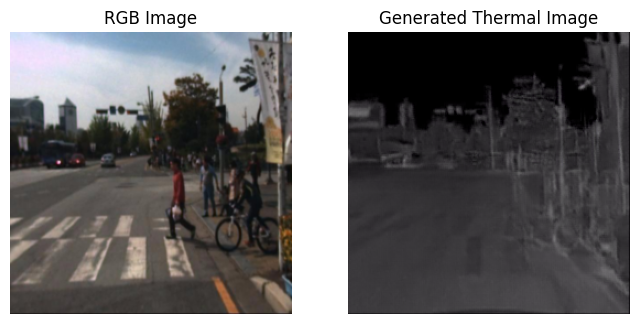

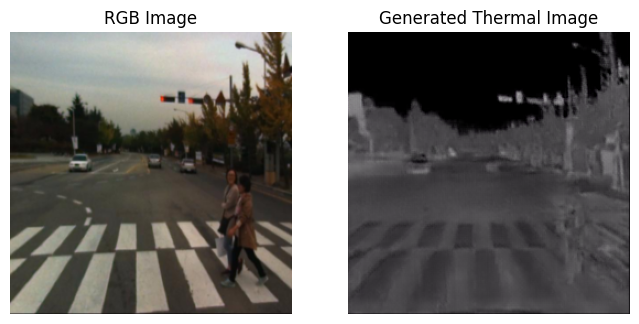

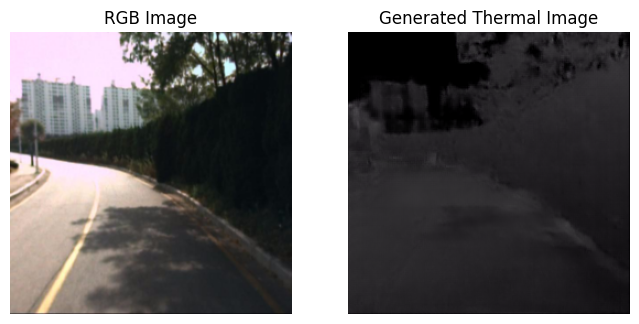

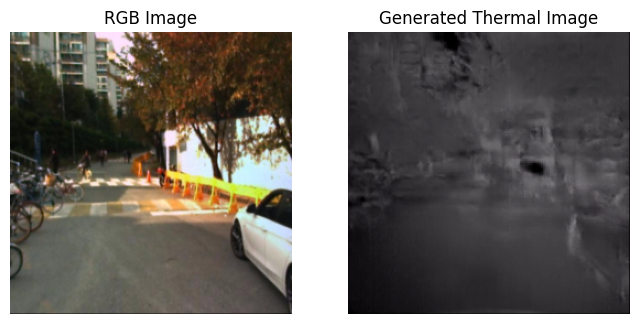

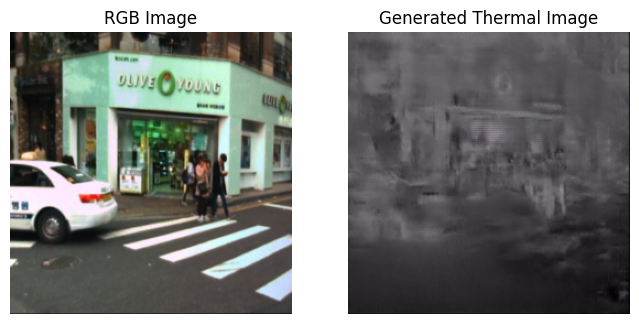

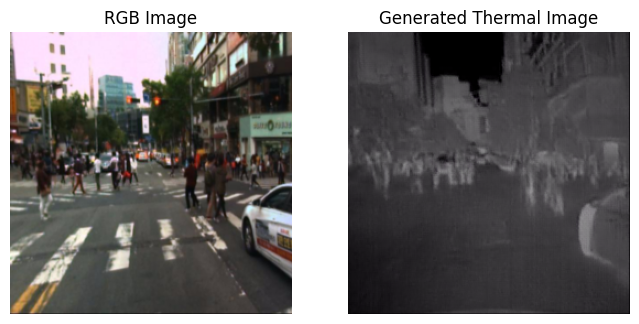

In [75]:
import matplotlib.pyplot as plt
import torch

# Create an iterator for the test loader
test_iter = iter(test_loader)

# Get and display the first 4 samples from the test loader
for _ in range(6):
    batch = next(test_iter)
    inputs = batch['image']

    # Move tensors to the CPU and detach gradients
    inputs = inputs.to(device)

    # Generate the Thermal image
    generated_output = generator(inputs)

    # Convert the generated output to a NumPy array
    generated_output = generated_output.permute(0, 2, 3, 1).squeeze(0)
    generated_output = generated_output.cpu().detach().numpy()

    # Convert the input RGB image to a NumPy array
    inputs = inputs.permute(0, 2, 3, 1).squeeze(0)
    inputs = inputs.cpu().detach().numpy()

    # Display the RGB and Generated Thermal images side by side
    plt.figure(figsize=(8, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(inputs)
    plt.axis('off')
    plt.title("RGB Image")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_output)
    plt.axis('off')
    plt.title("Generated Thermal Image")

    plt.show()